# 0. Install Dependencies and Bring in Data

In [1]:
pip install tensorflow pandas matplotlib numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [20]:
tf.debugging.set_log_device_placement(True)
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [22]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 2622s 376ms/step - loss: 0.0607 - val_loss: 0.0464
Epoch 2/5
6981/6981 [==============================] - 2519s 361ms/step - loss: 0.0455 - val_loss: 0.0412
Epoch 3/5
6981/6981 [==============================] - 2536s 363ms/step - loss: 0.0403 - val_loss: 0.0346
Epoch 4/5
6981/6981 [==============================] - 2567s 368ms/step - loss: 0.0359 - val_loss: 0.0330
Epoch 5/5
6981/6981 [==============================] - 2560s 367ms/step - loss: 0.0323 - val_loss: 0.0280


In [23]:
history.history
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

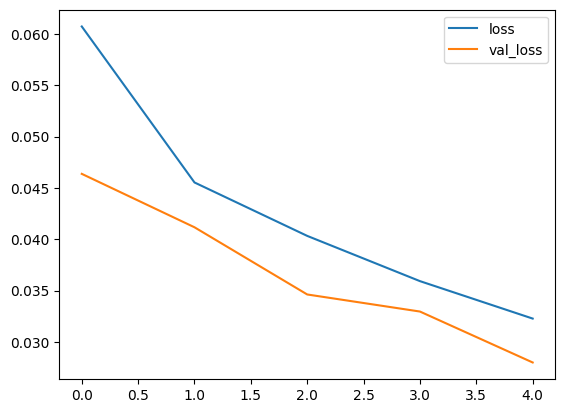

In [24]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [25]:
input_text = vectorizer('You freaking suck! I am going to kill you.')

In [26]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [27]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [28]:
res = model.predict(batch_X)

1/1 [==============================] - 1s 686ms/step


In [29]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [30]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 87ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [31]:
res.shape

(16, 6)

# 4. Evaluate Model

In [32]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 75ms/step


In [35]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8537142872810364, Recall:0.8450226187705994, Accuracy:0.49448344111442566


# 5. Test and Gradio

In [50]:
!python --version

Python 3.8.18


In [68]:
!pip install gradio==4.14.0 jinja2

  Using cached gradio-4.14.0-py3-none-any.whl.metadata (15 kB)
  Using cached gradio_client-0.8.0-py3-none-any.whl.metadata (7.1 kB)
Using cached gradio-4.14.0-py3-none-any.whl (16.6 MB)
Using cached gradio_client-0.8.0-py3-none-any.whl (305 kB)
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 0.5.2
    Uninstalling gradio_client-0.5.2:
      Successfully uninstalled gradio_client-0.5.2
  Attempting uninstall: gradio
    Found existing installation: gradio 3.45.0
    Uninstalling gradio-3.45.0:
      Successfully uninstalled gradio-3.45.0


In [69]:
!pip install ipywidgets

In [70]:
!pip install gradio typing-extensions

In [71]:
!pip install pydantic==2.5.0

In [72]:
!pip install typing-extensions --upgrade

In [73]:
import tensorflow as tf
import gradio as gr

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (C:\Users\dfram.DONGHYUN\anaconda3\envs\env\lib\site-packages\typing_extensions.py)

In [45]:
model.save('toxicity.h5')

C:\Users\dfram.DONGHYUN\anaconda3\envs\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
model = tf.keras.models.load_model('toxicity.h5')

In [85]:
input_str = vectorizer('You are not a very horrible person')

In [86]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 46ms/step


In [87]:
res >0.5

array([[ True, False, False, False, False, False]])

In [88]:
def score_comment(Comment):
    vectorized_comment = vectorizer([Comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text


In [89]:
interface = gr.Interface(fn=score_comment, 
                         inputs='text',
                        outputs='text')

NameError: name 'gr' is not defined

In [ ]:
interface.launch(share=True)


In [ ]:
interface.close()